In [1]:
versioninfo()

Julia Version 0.4.5
Commit 2ac304d (2016-03-18 00:58 UTC)
Platform Info:
  System: Linux (x86_64-unknown-linux-gnu)
  CPU: Intel(R) Core(TM) i5-3570 CPU @ 3.40GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Sandybridge)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.3


In [2]:
using DataFrames, Distributions, GLM, MixedModels, RCall
Pkg.status("DataFrames")
Pkg.status("Distributions")
Pkg.status("GLM")
Pkg.status("MixedModels")
Pkg.status("RCall")

 - DataFrames                    0.7.2
 - Distributions                 0.9.0
 - GLM                           0.5.2
 - MixedModels                   0.5.3
 - RCall                         0.4.1


# Cleaning and resaving the data sets

The sample data sets provided by Glen Thomas are "pen", "occ" and "dolocc".

In [3]:
R"""
load("pen_formula.RData")
load("pen_final_data.RData")
ls()
"""

RCall.RObject{RCall.StrSxp}
[1] "pen_final_data"    "Pen_Formula_final"


In [4]:
R"Pen_Formula_final"  # saved as a character string

RCall.RObject{RCall.StrSxp}
[1] "Buyer_Pos_P1~ Cpn_Trps_Shr_DPP_P3 + Fea_Trps_Shr_DPP_P3 + Dis_Trps_Shr_DPP_P3 + Cpn_Trps_Shr_DPP_P4 + AP_Trps_Shr_DPP_P4 + Cpn_Trps_Shr_DPP_P5 + AP_Trps_Shr_DPP_P5 + TPR_Trps_Shr_DPP_P7 + Dol_per_Trip_PRE_P8 + AP_Trps_Shr_DPP_P8 + UN_per_Trip_PRE_P2 + UN_per_Trip_PRE_P1 + Dis_Trps_Shr_DPP_P1 + Prd_1_Net_Pr_PRE + offset(log(Buyer_Pre_P1+1)) + group+(0+group|Creative_Groups)"


In [5]:
R"form <- eval(parse(text = Pen_Formula_final))"

RCall.RObject{RCall.LangSxp}
Buyer_Pos_P1 ~ Cpn_Trps_Shr_DPP_P3 + Fea_Trps_Shr_DPP_P3 + Dis_Trps_Shr_DPP_P3 + 
    Cpn_Trps_Shr_DPP_P4 + AP_Trps_Shr_DPP_P4 + Cpn_Trps_Shr_DPP_P5 + 
    AP_Trps_Shr_DPP_P5 + TPR_Trps_Shr_DPP_P7 + Dol_per_Trip_PRE_P8 + 
    AP_Trps_Shr_DPP_P8 + UN_per_Trip_PRE_P2 + UN_per_Trip_PRE_P1 + 
    Dis_Trps_Shr_DPP_P1 + Prd_1_Net_Pr_PRE + offset(log(Buyer_Pre_P1 + 
    1)) + group + (0 + group | Creative_Groups)


Before copying the data frame to Julia we reduce it to only those variables used in the formula, drop unused levels, and save in `.rds` (R Data Set) format using `xz` compression.

In [6]:
R"""
saveRDS(droplevels(subset(pen_final_data, 
    select = all.vars(form))),
    file = "pen_data.rds", compress = "xz")
""";

We reduce and save the "occ" and "dolocc" data similarly.

In [7]:
R"""load("occ_final_data.RData")"""

RCall.RObject{RCall.StrSxp}
[1] "occ_final_data"


In [8]:
R"""load("occ_formula.RData")"""

RCall.RObject{RCall.StrSxp}
[1] "Occ_Random_Formula_final"


In [9]:
R"occ_form <- eval(parse(text=Occ_Random_Formula_final))"

RCall.RObject{RCall.LangSxp}
Trps_POS_P1 ~ Trps_PRE_P3 + AP_Trps_Shr_DPP_P3 + Dol_per_Trip_PRE_P4 + 
    Cpn_Trps_Shr_DPP_P4 + Dis_Trps_Shr_DPP_P4 + AP_Trps_Shr_DPP_P6 + 
    Dol_per_Trip_PRE_P7 + Prd_7_Net_Pr_PRE + UN_per_Trip_PRE_P8 + 
    Dis_Trps_Shr_DPP_P8 + Cpn_UN_PRE_P2 + UN_per_Trip_PRE_P2 + 
    Cpn_Trps_Shr_DPP_P1 + AP_Trps_Shr_DPP_P1 + offset(log(Trps_PRE_P1 + 
    1)) + group + (0 + group | estimated_hh_income) + (0 + group | 
    hh_age) + (0 + group | number_of_children_in_living_Un) + 
    (0 + group | Creative_Groups)


In [10]:
R"""
saveRDS(droplevels(subset(occ_final_data, 
    select = all.vars(occ_form))),
    file = "occ_data.rds", compress = "xz")
""";

In [11]:
R"""load("dolocc_final_data.RData")"""

RCall.RObject{RCall.StrSxp}
[1] "dolocc_final_data"


In [12]:
R"""load("dolocc_formula.RData")"""

RCall.RObject{RCall.StrSxp}
[1] "dolocc_Formula_final"


In [13]:
R"dolocc_form <- eval(parse(text=dolocc_Formula_final))"

RCall.RObject{RCall.LangSxp}
Dol_per_Trip_POS_P1 ~ Trps_PRE_P4 + Cpn_Dol_per_Trip_DPP_P5 + 
    Cpn_UN_per_Trip_DPP_P8 + Dis_Trps_Shr_DPP_P8 + Trps_PRE_P2 + 
    Nonbuyer_Pre_P1 + offset(log(Dol_per_Trip_PRE_P1 + 1)) + 
    group + (0 + group | Creative_Groups)


In [14]:
R"""
saveRDS(droplevels(subset(dolocc_final_data, 
    select = all.vars(dolocc_form))),
    file = "dolocc_data.rds", compress = "xz")
""";

## Why use random effects and why use those offsets?

As I described in my talk in Chicago, the term "random effects" is a bit of a misnomer.  It is actually the levels of the grouping factor for the term that are random in the sense that if the study is repeated we would expect that these levels would change.  In other words they represent a random sample from some population.

The distinction between fixed and random-effects can be relaxed a bit if the number of levels is either very large or very small.  A factor with only a few levels is usually modelled as a fixed-effect, because it is difficult to estimate variances from small samples.  A factor with a large number of levels is often modelled as a random effect, even if the levels are reproducible, because the "shrinkage" of random effects allows for more stable computational methods.

All three models incorporate random-effects terms for `Creative_Groups`, which has only a few levels.

In [15]:
occ = rcopy("readRDS('occ_data.rds')");
using StatsBase
countmap(occ[:Creative_Groups])

Dict{Union{ASCIIString,DataArrays.NAtype},Int64} with 4 entries:
  "Cafe Steamers"        => 679
  "none"                 => 15512
  "Simply Cafe Steamers" => 436
  "Both"                 => 200

In [16]:
dolocc = rcopy("readRDS('dolocc_data.rds')");
countmap(dolocc[:Creative_Groups])

Dict{Union{ASCIIString,DataArrays.NAtype},Int64} with 4 entries:
  "Cafe Steamers"        => 679
  "none"                 => 14282
  "Simply Cafe Steamers" => 436
  "Both"                 => 200

In [17]:
pen = rcopy("readRDS('pen_data.rds')");
countmap(pen[:Creative_Groups])

Dict{Union{ASCIIString,DataArrays.NAtype},Int64} with 4 entries:
  "Cafe Steamers"        => 18327
  "none"                 => 510011
  "Simply Cafe Steamers" => 10896
  "Both"                 => 5038

For each of the data sets `Creative_Groups` has only 4 levels.  It is unusual to use random-effects for such a factor.  The other problem is the relationshup between `group` and `Creative_Groups`.  The `group` factor is just an indicator of `none` versus the other three levels of `Creative_Groups`.

In [18]:
counts(pen[:group].refs, pen[:Creative_Groups].refs)

2x4 Array{Int64,2}:
    0      0      0  510011
 5038  18327  10896       0

In [19]:
counts(occ[:group].refs, occ[:Creative_Groups].refs)

2x4 Array{Int64,2}:
   0    0    0  15512
 200  679  436      0

In [20]:
counts(dolocc[:group].refs, dolocc[:Creative_Groups].refs)

2x4 Array{Int64,2}:
   0    0    0  14282
 200  679  436      0

This means that a term of the form `(1 + group | Creative_Group)` or `(0 + group | Creative_Group)` cannot be estimated because `group` is constant within each level of `Creative_Group`.  Trying to define such terms is like trying to estimate an intercept and slope from a single data point.  It may be that `glmer` produces estimates but that is only because of the estimation method, which gets expressed as a general optimization problem.  In such cases it is difficult to know if you have converged to an optimum or if you are simply failing to make progress because the model is over-specified.

The next issue is the `offset` term.  Sometimes such an offset is used in a GLM with a Poisson distribution and a log-link.  Such a term is used when the response is a rate rather than a count.  See [this discussion](http://stats.stackexchange.com/questions/11182/when-to-use-an-offset-in-a-poisson-regression).  It seems unlikely that this is the case for the `occ` (Occasions) data.  For the `pen` (Penetration) data it is not appropriate to use `offset(log(Buyer_Pre_P1 + 1))` because the link is a logit link, not a log link.

One way to assess this is to compare models fit with this term as an offset and with the `Buyer_Pre_P1` as a fixed-effects term.  Fitting with a fixed effects term for `Buyer_Pre_P1` or for `log(Buyer_Pre_P1 + 1)` is the same in terms of the deviance, because `Buyer_Pre_P1` only has two levels.

In [21]:
gm1 = glm(Buyer_Pos_P1 ~ 1 + Buyer_Pre_P1, pen, Bernoulli())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Bernoulli,GLM.LogitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Buyer_Pos_P1 ~ 1 + Buyer_Pre_P1

Coefficients:
              Estimate Std.Error z value Pr(>|z|)
(Intercept)   -3.91704 0.0100029 -391.59   <1e-99
Buyer_Pre_P1   2.80325 0.0185983 150.726   <1e-99


In [22]:
deviance(gm1)

124892.9737695327

The estimated coefficient, 2.803, for `Buyer_Pre_P1` is so large because that indicator is so highly predictive `Buyer_Pos_P1`.

In [23]:
counts(convert(Vector{Int},pen[:Buyer_Pre_P1]),
convert(Vector{Int},pen[:Buyer_Pos_P1]))

2x2 Array{Int64,2}:
 512215  10193
  16460   5404

If, as in the suggested model, we incorporate an offset the fit is

In [24]:
gm2 = glm(Buyer_Pos_P1 ~ 1, pen, Bernoulli(), 
    offset = log(Array(pen[:Buyer_Pre_P1] + 1)))

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Bernoulli,GLM.LogitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Buyer_Pos_P1 ~ +1

Coefficients:
             Estimate Std.Error  z value Pr(>|z|)
(Intercept)  -3.56168 0.0075507 -471.702   <1e-99


In [25]:
deviance(gm2)

135276.7255031027

`gm2` is a much, much poorer fit to the data than is `gm1`, as assessed by the change in the deviance.

In [26]:
deviance(gm2) - deviance(gm1)

10383.751733569996

The change in deviance would have a Χ² distribution with 1 degree of freedom if the model with the offset was suitable.  The probability of this value or something even large (i.e. the p-value) is essentially zero.

In [27]:
ccdf(Chisq(1), deviance(gm2) - deviance(gm1))

0.0

Another way of assessing whether the offset is suitable is to incorporate it while keeping `Buyer_Pre_P1` in the model.

In [28]:
gm3 = glm(Buyer_Pos_P1 ~ 1 + Buyer_Pre_P1, pen, Bernoulli(),
offset = log(Array(pen[:Buyer_Pre_P1] + 1)))

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Bernoulli,GLM.LogitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Buyer_Pos_P1 ~ 1 + Buyer_Pre_P1

Coefficients:
              Estimate Std.Error z value Pr(>|z|)
(Intercept)   -3.91704 0.0100029 -391.59   <1e-99
Buyer_Pre_P1    2.1101 0.0185983 113.457   <1e-99


In [29]:
deviance(gm3)

124892.97376953263

Notice that the deviance is the same for `gm1` and `gm3`.  In other words, the offset does not affect the quality of the fit, all it does in this case is to subtract `log(2.)` from the estimate of the coefficient for `Buyer_Pre_P1`.

In [30]:
coef(gm1)[2] - coef(gm3)[2]

0.6931471805599521

In [31]:
log(2.)

0.6931471805599453

We can repeat this for the `occ` and `dolocc` data sets.  In these cases we must create a column of `log(Trps_PRE_P1 + 1)` in the data frame before fitting the model.

In [32]:
occ[:log_Trps_PRE_P1] = log(occ[:Trps_PRE_P1] + 1);
gm4 = glm(Trps_POS_P1 ~ 1 + log_Trps_PRE_P1, occ, Poisson())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Poisson,GLM.LogLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Trps_POS_P1 ~ 1 + log_Trps_PRE_P1

Coefficients:
                  Estimate  Std.Error z value Pr(>|z|)
(Intercept)      0.0432075 0.00831807 5.19441    <1e-6
log_Trps_PRE_P1   0.700307 0.00714241 98.0491   <1e-99


In [33]:
deviance(gm4)

8093.878604834652

In [34]:
gm5 = glm(Trps_POS_P1 ~ 1, occ, Poisson(), 
offset = Array(occ[:log_Trps_PRE_P1]))

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Poisson,GLM.LogLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Trps_POS_P1 ~ +1

Coefficients:
              Estimate  Std.Error  z value Pr(>|z|)
(Intercept)  -0.224828 0.00621736 -36.1613   <1e-99


In [35]:
deviance(gm5) - deviance(gm4)

1874.521412914357

In [36]:
gm6 = glm(Trps_POS_P1 ~ 1 + log_Trps_PRE_P1, occ, Poisson(),
offset = Array(occ[:log_Trps_PRE_P1]))

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Poisson,GLM.LogLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Trps_POS_P1 ~ 1 + log_Trps_PRE_P1

Coefficients:
                  Estimate  Std.Error  z value Pr(>|z|)
(Intercept)      0.0432075 0.00831807  5.19441    <1e-6
log_Trps_PRE_P1  -0.299693 0.00714241 -41.9596   <1e-99


In [37]:
deviance(gm6)

8093.878604834654

Again the deviance for `gm6` is the same as that of `gm4` and the coefficient for `log_Trps_PRE_P1` is significantly different from 0.  The z-value is -41.96 and the p-value is less than 1e-99.

Turning our attention to the `dolocc` data

In [38]:
describe(dolocc[:Dol_per_Trip_POS_P1])

Summary Stats:
Mean:         3.981794
Minimum:      1.090000
1st Quartile: 2.690000
Median:       3.000000
3rd Quartile: 5.000000
Maximum:      32.280000


In [39]:
describe(dolocc[:Dol_per_Trip_PRE_P1])

Summary Stats:
Mean:         1.518385
Minimum:      0.000000
1st Quartile: 0.000000
Median:       0.000000
3rd Quartile: 2.790000
Maximum:      27.500000


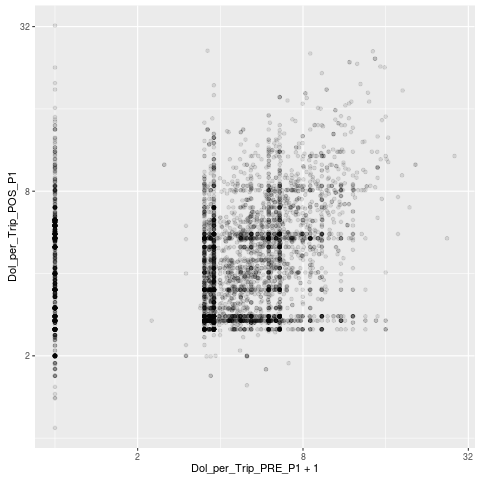

RCall.RObject{RCall.VecSxp}


In [40]:
R"""
suppressPackageStartupMessages(library(ggplot2))
dolocc <- readRDS("dolocc_data.rds")
p <- ggplot(dolocc, aes(x = Dol_per_Trip_PRE_P1 + 1, 
y = Dol_per_Trip_POS_P1)) + geom_point(alpha=0.1) +
scale_x_continuous(trans="log2") + scale_y_continuous(trans="log2")
"""

In [41]:
dolocc[:log_PRE_P1] = log(Array(dolocc[:Dol_per_Trip_PRE_P1]) + 1);

In [42]:
gm7 = glm(Dol_per_Trip_POS_P1 ~ 1 + log_PRE_P1, dolocc, 
  Gamma(), LogLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Gamma,GLM.LogLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Dol_per_Trip_POS_P1 ~ 1 + log_PRE_P1

Coefficients:
             Estimate  Std.Error z value Pr(>|z|)
(Intercept)   1.27276 0.00425336 299.237   <1e-99
log_PRE_P1   0.175394 0.00436899 40.1453   <1e-99


In [43]:
gm8 = glm(Dol_per_Trip_POS_P1 ~ 1, dolocc, Gamma(), LogLink(), 
offset = Array(dolocc[:log_PRE_P1]))

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Gamma,GLM.LogLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Dol_per_Trip_POS_P1 ~ +1

Coefficients:
             Estimate  Std.Error z value Pr(>|z|)
(Intercept)  0.988204 0.00520555 189.837   <1e-99


In [44]:
deviance(gm8) - deviance(gm7)

5541.106186674557

In none of these cases is the `offset` term appropriate.

### `group` and `Creative_Groups`

As I stated above, `group` is redundant in the sense that it is simply an indicator of the value `none` for `Creative_Groups`.  Although it is possible to work with `Creative_Groups` the names of the levels suggest to me that there are really two binary variables here, `Cafe_Steamers` and `Simply_Cafe_Steamers`.  The 3 degrees of freedom for `Creative_Groups` would more sensibly be modelled as these two variables and their interaction.

In [45]:
occ[:Cafe] = pool([v ∈ ["Both", "Cafe Steamers"] ? 'Y' : 'N'
    for v in occ[:Creative_Groups]]);

In [46]:
occ[:Simply] = pool([v ∈ ["Both", "Simply Cafe Steamers"] ? 'Y' : 'N'
    for v in occ[:Creative_Groups]]);

In [47]:
gm9 = glm(Trps_POS_P1 ~ 1 + log_Trps_PRE_P1 + Cafe*Simply, 
    occ, Poisson())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Poisson,GLM.LogLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Trps_POS_P1 ~ 1 + log_Trps_PRE_P1 + Cafe + Simply + Cafe & Simply

Coefficients:
                        Estimate  Std.Error  z value Pr(>|z|)
(Intercept)            0.0213166 0.00861031  2.47571   0.0133
log_Trps_PRE_P1         0.704171 0.00714929  98.4952   <1e-99
Cafe - Y                0.253451  0.0297098  8.53087   <1e-16
Simply - Y              0.274196  0.0359151  7.63457   <1e-13
Cafe - Y & Simply - Y  -0.446053  0.0725704 -6.14649    <1e-9


In [48]:
deviance(gm9)

7975.647173114192

In [49]:
gm10 = glm(Trps_POS_P1 ~ 1 + log_Trps_PRE_P1 + Creative_Groups,
    occ, Poisson())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Poisson,GLM.LogLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Trps_POS_P1 ~ 1 + log_Trps_PRE_P1 + Creative_Groups

Coefficients:
                                          Estimate  Std.Error  z value Pr(>|z|)
(Intercept)                                0.10291  0.0562553  1.82934   0.0673
log_Trps_PRE_P1                           0.704171 0.00714929  98.4952   <1e-99
Creative_Groups - Cafe Steamers           0.171857  0.0630361  2.72633   0.0064
Creative_Groups - Simply Cafe Steamers    0.192603  0.0661875  2.90996   0.0036
Creative_Groups - none                  -0.0815935   0.056355 -1.44785   0.1477


In [50]:
deviance(gm10)

7975.647173114197

The two models are equivalent, they are simply different ways of writing the same model.  We could reproduce the coefficients if we used `none` as the reference level for `Creative_Groups`.  At present it is easier to do this in R.

In [51]:
R"occ <- readRDS('occ_data.rds')";
occ[:Creative_Groups] = rcopy(R"relevel(occ$Creative_Groups, 'none')");

In [52]:
gm11 = glm(Trps_POS_P1 ~ 1 + log_Trps_PRE_P1 + Creative_Groups,
    occ, Poisson())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Poisson,GLM.LogLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Trps_POS_P1 ~ 1 + log_Trps_PRE_P1 + Creative_Groups

Coefficients:
                                         Estimate  Std.Error z value Pr(>|z|)
(Intercept)                             0.0213166 0.00861031 2.47571   0.0133
log_Trps_PRE_P1                          0.704171 0.00714929 98.4952   <1e-99
Creative_Groups - Both                  0.0815935   0.056355 1.44785   0.1477
Creative_Groups - Cafe Steamers          0.253451  0.0297098 8.53087   <1e-16
Creative_Groups - Simply Cafe Steamers   0.274196  0.0359151 7.63457   <1e-13


These results may seem to contradict those of `gm10` where the interaction is highly significant but the main effects for `Cafe` and for `Simply`, while still significant are not as highly significant.  It is one of those cases where you need to know, "compared to what?" before you can answer the question of whether a coefficient is important.  In this case the coefficient for "Both" is based on only 200 out of the 16,827 cases and is not highly significant.  In `gm9` the p-value for the interaction is equivalent to comparing this model to

In [53]:
gm12 = glm(Trps_POS_P1 ~ 1 + log_Trps_PRE_P1 + Cafe + Simply, occ, Poisson())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Poisson,GLM.LogLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Trps_POS_P1 ~ 1 + log_Trps_PRE_P1 + Cafe + Simply

Coefficients:
                 Estimate  Std.Error z value Pr(>|z|)
(Intercept)      0.026322 0.00855577 3.07652   0.0021
log_Trps_PRE_P1  0.702607  0.0071418 98.3796   <1e-99
Cafe - Y         0.171707  0.0275984 6.22161    <1e-9
Simply - Y       0.152404  0.0317744 4.79644    <1e-5


In [54]:
deviance(gm12) - deviance(gm9)

39.13510916881751

In [55]:
ccdf(Chisq(1), ans)

3.954680086539803e-10

The fact that the coefficient for the interaction in `gm9` is highly significant and negative indicates that the `Cafe` and `Simply` factors increase the mean number of trips but the combination of the two has an effect that is lower than simply adding these two effects.

## Full GLM and GLMM fits

In [56]:
fpen = Buyer_Pos_P1 ~ 1 + Cpn_Trps_Shr_DPP_P3 + Fea_Trps_Shr_DPP_P3 +
    Dis_Trps_Shr_DPP_P3 + Cpn_Trps_Shr_DPP_P4 + AP_Trps_Shr_DPP_P4 +
    Cpn_Trps_Shr_DPP_P5 + AP_Trps_Shr_DPP_P5 + TPR_Trps_Shr_DPP_P7 +
    Dol_per_Trip_PRE_P8 

+ AP_Trps_Shr_DPP_P8 + UN_per_Trip_PRE_P2 + 
    UN_per_Trip_PRE_P1 + Dis_Trps_Shr_DPP_P1 + Prd_1_Net_Pr_PRE + 
    Buyer_Pre_P1 + Cafe * Simply;

In [57]:
pen[:Cafe] = pool([v ∈ ["Cafe Steamers", "Both"] ? 'Y' : 'N'
    for v in pen[:Creative_Groups]]);
pen[:Simply] = pool([v ∈ ["Simply Cafe Steamers", "Both"] ? 'Y' : 'N'
    for v in pen[:Creative_Groups]]);

In [58]:
gm13 = glm(fpen, pen, Bernoulli())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Bernoulli,GLM.LogitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Buyer_Pos_P1 ~ 1 + Cpn_Trps_Shr_DPP_P3 + Fea_Trps_Shr_DPP_P3 + Dis_Trps_Shr_DPP_P3 + Cpn_Trps_Shr_DPP_P4 + AP_Trps_Shr_DPP_P4 + Cpn_Trps_Shr_DPP_P5 + AP_Trps_Shr_DPP_P5 + TPR_Trps_Shr_DPP_P7 + Dol_per_Trip_PRE_P8 + AP_Trps_Shr_DPP_P8 + UN_per_Trip_PRE_P2 + UN_per_Trip_PRE_P1 + Dis_Trps_Shr_DPP_P1 + Prd_1_Net_Pr_PRE + Buyer_Pre_P1 + Cafe + Simply + Cafe & Simply

Coefficients:
                         Estimate Std.Error   z value Pr(>|z|)
(Intercept)              -3.86708 0.0705666  -54.8005   <1e-99
Cpn_Trps_Shr_DPP_P3     -0.754973   0.78236 -0.964995   0.3345
Fea_Trps_Shr_DPP_P3     -0.570443  0.771117 -0.739762   0.4594
Dis_Trps_Shr_DPP_P3     -0.347381   1.50455 -0.230887   0.8174
Cpn_Trps_Shr_DPP_P4     -0.541164   0.46364  -1.16721   0.2431
AP_Trps_Shr_DPP_P4

In [59]:
fpenmm = Buyer_Pos_P1 ~ 1 + Cpn_Trps_Shr_DPP_P3 + Fea_Trps_Shr_DPP_P3 +
    Dis_Trps_Shr_DPP_P3 + Cpn_Trps_Shr_DPP_P4 + AP_Trps_Shr_DPP_P4 +
    Cpn_Trps_Shr_DPP_P5 + AP_Trps_Shr_DPP_P5 + TPR_Trps_Shr_DPP_P7 +
    Dol_per_Trip_PRE_P8 + AP_Trps_Shr_DPP_P8 + UN_per_Trip_PRE_P2 +
    UN_per_Trip_PRE_P1 + Dis_Trps_Shr_DPP_P1 + Prd_1_Net_Pr_PRE +
    Buyer_Pre_P1 + (1 | Creative_Groups);

In [60]:
glmm1 = fit!(glmm(fpenmm, pen, Bernoulli()))

Generalized Linear Mixed Model fit by minimizing the Laplace approximation to the deviance
  Formula: Buyer_Pos_P1 ~ 1 + Cpn_Trps_Shr_DPP_P3 + Fea_Trps_Shr_DPP_P3 + Dis_Trps_Shr_DPP_P3 + Cpn_Trps_Shr_DPP_P4 + AP_Trps_Shr_DPP_P4 + Cpn_Trps_Shr_DPP_P5 + AP_Trps_Shr_DPP_P5 + TPR_Trps_Shr_DPP_P7 + Dol_per_Trip_PRE_P8 + AP_Trps_Shr_DPP_P8 + UN_per_Trip_PRE_P2 + UN_per_Trip_PRE_P1 + Dis_Trps_Shr_DPP_P1 + Prd_1_Net_Pr_PRE + Buyer_Pre_P1 + (1 | Creative_Groups)
  Distribution: Distributions.Bernoulli
  Link: GLM.LogitLink

  Deviance (Laplace approximation): 122553.2502

Variance components:
                     Column     Variance   Std.Dev.  
 Creative_Groups (Intercept)  0.028042828 0.16745993

 Number of obs: 544272; levels of grouping factors: 4


Fixed-effects parameters:
                       Estimate  Std.Error  z value P(>|z|)
(Intercept)            -3.59282  0.0878157 -40.9132  <1e-99
Cpn_Trps_Shr_DPP_P3   -0.754884    0.14404 -5.24078   <1e-6
Fea_Trps_Shr_DPP_P3   -0.570425   0.141

In [61]:
ranef(glmm1)

1-element Array{Array{Float64,2},1}:
 1x4 Array{Float64,2}:
 0.101533  0.0458348  0.126917  -0.274285

In [62]:
levels(pen[:Creative_Groups])'

1x4 Array{ASCIIString,2}:
 "Both"  "Cafe Steamers"  "Simply Cafe Steamers"  "none"

You can see that the coefficient estimates for the variables that `gm13` and `glmm1` have in common are similar but the standard errors are much smaller in `glmm1`.  That may be a mistake on my part.

In [63]:
@time fit!(glmm(fpenmm, pen, Bernoulli()));

104.567514 seconds (58.79 k allocations: 476.001 MB, 0.12% gc time)


In [64]:
dolocc[:Cafe] = pool([v ∈ ["Cafe Steamers", "Both"] ? 'Y' : 'N'
    for v in dolocc[:Creative_Groups]]);
dolocc[:Simply] = pool([v ∈ ["Simply Cafe Steamers", "Both"] ? 'Y' : 'N'
    for v in dolocc[:Creative_Groups]]);

In [65]:
fdolocc = Dol_per_Trip_POS_P1 ~ 1 + Trps_PRE_P4 + 
    Cpn_Dol_per_Trip_DPP_P5 + Cpn_UN_per_Trip_DPP_P8 + 
    Dis_Trps_Shr_DPP_P8 + Trps_PRE_P2 + Nonbuyer_Pre_P1 +
    log_PRE_P1 + Cafe * Simply;

In [66]:
gm14 = glm(fdolocc, dolocc, Gamma(), LogLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Gamma,GLM.LogLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Dol_per_Trip_POS_P1 ~ 1 + Trps_PRE_P4 + Cpn_Dol_per_Trip_DPP_P5 + Cpn_UN_per_Trip_DPP_P8 + Dis_Trps_Shr_DPP_P8 + Trps_PRE_P2 + Nonbuyer_Pre_P1 + log_PRE_P1 + Cafe + Simply + Cafe & Simply

Coefficients:
                            Estimate   Std.Error   z value Pr(>|z|)
(Intercept)                 0.715024   0.0274101   26.0861   <1e-99
Trps_PRE_P4              -0.00811152  0.00152859  -5.30655    <1e-6
Cpn_Dol_per_Trip_DPP_P5   -0.0122007  0.00349129  -3.49461   0.0005
Cpn_UN_per_Trip_DPP_P8    -0.0114091  0.00536827  -2.12529   0.0336
Dis_Trps_Shr_DPP_P8       -0.0120619     0.04112 -0.293334   0.7693
Trps_PRE_P2              -0.00832668 0.000982911  -8.47146   <1e-16
Nonbuyer_Pre_P1             0.566353   0.0274538   20.6293   <1e-93
log_PRE_P1                  0.5134

In [67]:
@time glm(fdolocc, dolocc, Gamma(), LogLink());

  0.028512 seconds (1.88 k allocations: 6.997 MB)


In [68]:
deviance(gm14)

2118.6466094330053

In [69]:
fdoloccmm = Dol_per_Trip_POS_P1 ~ 1 + Trps_PRE_P4 + Cpn_Dol_per_Trip_DPP_P5 + 
    Cpn_UN_per_Trip_DPP_P8 + Dis_Trps_Shr_DPP_P8 + Trps_PRE_P2 + 
Nonbuyer_Pre_P1 + log_PRE_P1 + (1 | Creative_Groups);

In [70]:
glmm2 = fit!(glmm(fdoloccmm, dolocc, Gamma(), LogLink()))

Generalized Linear Mixed Model fit by minimizing the Laplace approximation to the deviance
  Formula: Dol_per_Trip_POS_P1 ~ 1 + Trps_PRE_P4 + Cpn_Dol_per_Trip_DPP_P5 + Cpn_UN_per_Trip_DPP_P8 + Dis_Trps_Shr_DPP_P8 + Trps_PRE_P2 + Nonbuyer_Pre_P1 + log_PRE_P1 + (1 | Creative_Groups)
  Distribution: Distributions.Gamma
  Link: GLM.LogLink

  Deviance (Laplace approximation): 2130.5473

Variance components:
                     Column     Variance   Std.Dev.  
 Creative_Groups (Intercept)  0.006619406 0.08135973

 Number of obs: 15597; levels of grouping factors: 4


Fixed-effects parameters:
                            Estimate  Std.Error   z value P(>|z|)
(Intercept)                 0.837647  0.0812607   10.3082  <1e-24
Trps_PRE_P4              -0.00809765 0.00373453  -2.16832  0.0301
Cpn_Dol_per_Trip_DPP_P5   -0.0122831 0.00852966  -1.44005  0.1499
Cpn_UN_per_Trip_DPP_P8    -0.0112872  0.0131153  -0.86061  0.3895
Dis_Trps_Shr_DPP_P8       -0.0147547   0.100456 -0.146877  0.8832
Trps_PRE

In [71]:
levels(dolocc[:Creative_Groups])'

1x4 Array{ASCIIString,2}:
 "Both"  "Cafe Steamers"  "Simply Cafe Steamers"  "none"

In [72]:
ranef(glmm2)

1-element Array{Array{Float64,2},1}:
 1x4 Array{Float64,2}:
 0.0326339  0.0623265  0.0273756  -0.122336

In [73]:
@time fit!(glmm(fdoloccmm, dolocc, Gamma(), LogLink()));

  5.635222 seconds (93.74 k allocations: 10.883 MB)


In [76]:
foccmm = Trps_POS_P1 ~ 1 + Trps_PRE_P3 + AP_Trps_Shr_DPP_P3 +
    Dol_per_Trip_PRE_P4 + Cpn_Trps_Shr_DPP_P4 + Dis_Trps_Shr_DPP_P4 +
    AP_Trps_Shr_DPP_P6 + Dol_per_Trip_PRE_P7 + Prd_7_Net_Pr_PRE + 
    UN_per_Trip_PRE_P8 + Dis_Trps_Shr_DPP_P8 + Cpn_UN_PRE_P2 +
    UN_per_Trip_PRE_P2 + Cpn_Trps_Shr_DPP_P1 + AP_Trps_Shr_DPP_P1 + 
    log_Trps_P1 + group + (1 + group | estimated_hh_income) +
    (1 + group | hh_age) + 
    (1 + group | number_of_children_in_living_Un) + 
    (1 | Creative_Groups);

In [77]:
occ[:log_Trps_P1] = log(occ[:Trps_PRE_P1] + 1);

In [78]:
glmm3 = fit!(glmm(foccmm, occ, Poisson()))

LoadError: LoadError: MethodError: `*` has no method matching *(::MixedModels.VectorReMat{Float64,ASCIIString,UInt8}, ::MixedModels.ScalarReMat{Float64,ASCIIString,UInt8})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...)
  *{T}(!Matched::Diagonal{T}, ::MixedModels.ScalarReMat{T,S,R<:Integer})
while loading In[78], in expression starting on line 1

I need to write more code to be able to fit this model.  I'm not sure what to do for a GLM because there as so many interaction terms.